# Intro

For the following, we are going to build a basic image reconigition model to be used in a Stitch IOS app
We will use the  [CIFAIR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset for training.

This dataset contains images in 10 classes, with 6000 images per class.

Its a well used dataset for Machine Learning, and it will be a good start for our project.

Since the dataset is fairly small, we can train the model locally. 

Note, this notebook is currently being hosted on Google Colab. But you should be able to download this notebook, create a virtual enviorment using virtualenv or anaconda.

You will need to install the following packages:


```
tensorflow
matplotlib
numpy
coremltools

```

# Running this notenook

This notebook is currently being hosted on [Google Colab](https://colab.research.google.com). Colaboratory is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud

You can view the notebook and run the code [here](https://colab.research.google.com/github/tbass134/colab_notebooks/blob/master/Image_Recognition_Tensorflow_CoreML.ipynb)

# Building out the Model

First thing we need to do is to import our packages


In [0]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

Notice, were using Keras as a backend for Tensorflow.
Keras is a great framework that allows you to build models easier, without having to use the more verbose methods in Tensorflow. More information about Keras is [here](https://www.tensorflow.org/guide/keras): 

Next, we'll load the CIFAR dataset. Using Keras, we're able to download the dataset very easily.

We split the dataset into 2 groups, one for training `(x_train, y_train)`, the other for testing `(x_test, y_test)`. 

Splitting the data set allows the model to learn from the training set, then, when we test the model, we want to see how well it learned, by using the test set. This will give us our accuracy, or, how we'll the model did.

In [2]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

print('y_train shape', y_train.shape)
print(x_test.shape[0], 'test samples')

print('x_test shape', x_test.shape)
print(y_test.shape[0], 'test samples')


Using TensorFlow backend.


170500096/170498071 [==============================] - 46s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
y_train shape (50000, 1)
10000 test samples
x_test shape (10000, 32, 32, 3)
10000 test samples


Next, we'll declair some constants
`batch_size` is the number of samples that going to be propagated through the network. 

`epochs` are how many times we train on the full dataset

`class_names` is a list of all the possible lables in the CIFAR-10 dataset.
We'll use this later, when coverting our model into CoreML

In [0]:
# Declare variables
batch_size = 32 
# 32 examples in a mini-batch, smaller batch size means more updates in one epoch
epochs = 100
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [0]:
def plot_images(x, y, number_of_images=5):
  fig, axes1 = plt.subplots(number_of_images,number_of_images,figsize=(10,10))
  for j in range(number_of_images):
      for k in range(number_of_images):
          i = np.random.choice(range(len(x)))
          title = class_names[y[i:i+1][0][0]]
          axes1[j][k].title.set_text(title)
          axes1[j][k].set_axis_off()
          axes1[j][k].imshow(x[i:i+1][0])        

First, lets have a look at the images.
We have a function that plots a series of images and their corresponding label

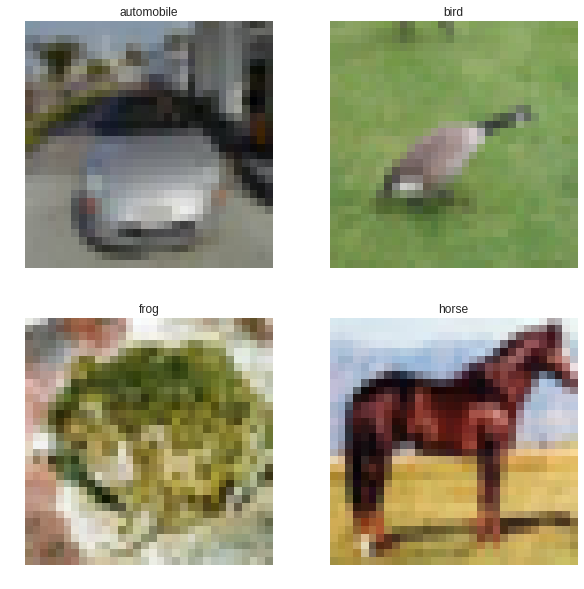

In [66]:
plot_images(x_train, y_train, number_of_images=2)

Now, we'll setup a simple model. You don't need to understand everthing going on here. But what we are basiclly doing is creating a deep neural network using a few convolutions, dropout, and max pooling

At the end, we'll flatten the network and use Relu, followed by a Softmax. 
This will give us a vector (1-dimenstion matrix), filled with mostly 0's

It will look like this

```
[0,0,0,0,0,0,1,0,0,0]
```

This vector corrsponds to the given label from the image
So in this example, the `1` in the 7'th place would be a frog, since 'frog' is at the 7th place in `class_names` list

---

The following shows the entire network.

In [0]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

That's it! 

# Training The Model

First we compile the model to get its loss.
The loss is a measure of how well the model did during testing. A high loss, means that the model did poorly. 

We'll use the Adam Optimizer to calucate the loss. You can learn more about Optimizers in keras [here](https://keras.io/optimizers/)

Then we'll call `.fit` which will train the model for 100 epochs. This means that the full training dataset will trained 100 times,
The `batch_size` of 32 is the number samples that going to be propagated through the network

We then see how well it did after every echo using `model.evaluate`
It gives us a score for the model (higher numbers are better) and the loss (lower numbers are better)

---

Note, this took about 15 minutes  running on Colab. If you just wants to see the results quicker, just set the `epochs` parameter to 1 or 2. Its accuracy wont be as good, however.



In [70]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

# Train the model
model.fit(x_train / 255.0, tf.keras.utils.to_categorical(y_train),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          validation_data=(x_test / 255.0, tf.keras.utils.to_categorical(y_test))
          )

# Evaluate the model
scores = model.evaluate(x_test / 255.0, tf.keras.utils.to_categorical(y_test))

print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 32s 641us/step - loss: 1.6316 - acc: 0.3976 - val_loss: 1.4677 - val_acc: 0.4692
Epoch 2/100
50000/50000 [==============================] - 32s 632us/step - loss: 1.4277 - acc: 0.4804 - val_loss: 1.2824 - val_acc: 0.5430
Epoch 3/100
50000/50000 [==============================] - 31s 619us/step - loss: 1.2916 - acc: 0.5360 - val_loss: 1.1822 - val_acc: 0.5742
Epoch 4/100
50000/50000 [==============================] - 31s 620us/step - loss: 1.1982 - acc: 0.5716 - val_loss: 1.0952 - val_acc: 0.6105
Epoch 5/100
50000/50000 [==============================] - 31s 619us/step - loss: 1.1240 - acc: 0.6007 - val_loss: 1.0197 - val_acc: 0.6409
Epoch 6/100
50000/50000 [==============================] - 31s 621us/step - loss: 1.0665 - acc: 0.6242 - val_loss: 0.9897 - val_acc: 0.6535
Epoch 7/100
50000/50000 [==============================] - 31s 620us/step - loss: 1.0082 - acc: 0.6477 - val_l

Our final accuracy was 81%, and our loss was 0.7, which is pretty good,

To reiterate, accuracy is how well the model was able to classify each image, whille loss indicate how bad the model's predictions were.

For more information, check out this defination of loss and accuracy on [Google
s Machine Learning crash course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/training-and-loss)

# Coverting the model to CoreML

After we have trained the model, we can save the model, then convert into the coreML format.



---

First, we need to save the trained model

In [0]:
model.save('cifar-model.h5')


Next, we'll use CoremlTools to convert the model into a format that our Stitch app can use. 

First, we'll install coremltools, which will help us convert the model into something our IOS app can use.



---

Note, we use `pip` to install it, since were running on Collab. to run in locally, just add this package into your virtual enviroment



In [73]:
!pip install coremltools

    100% |████████████████████████████████| 2.5MB 9.9MB/s 
  Found existing installation: six 1.11.0
    Uninstalling six-1.11.0:
      Successfully uninstalled six-1.11.0



Next, we'll  convert the saved model into CoreML. 


---

Since we have used Keras to train our model, Its really easy to convert to CoreML. However, this varies based on how you built your model. CoreML tools has other functions to use for other machine learning packages including Tensorflow and Scikit Learn.  See the [coremltools repo](https://github.com/apple/coremltools) for more info.




In [83]:
from keras.models import load_model  
import coremltools

model = load_model('cifar-model.h5')
coreml_model = coremltools.converters.keras.convert(model,
	input_names="image",
	image_input_names="image",
	image_scale=1/255.0,
	class_labels=class_names)

coreml_model.save('CIFAR.mlmodel')

0 : conv2d_input, <keras.engine.topology.InputLayer object at 0x7fa7c829fac8>
1 : conv2d, <keras.layers.convolutional.Conv2D object at 0x7fa7c829f358>
2 : conv2d__activation__, <keras.layers.core.Activation object at 0x7fa7c75bf198>
3 : conv2d_1, <keras.layers.convolutional.Conv2D object at 0x7fa7c80e40b8>
4 : conv2d_1__activation__, <keras.layers.core.Activation object at 0x7fa7c75bf438>
5 : max_pooling2d, <keras.layers.pooling.MaxPooling2D object at 0x7fa7c80e4550>
6 : conv2d_2, <keras.layers.convolutional.Conv2D object at 0x7fa7c77434a8>
7 : conv2d_2__activation__, <keras.layers.core.Activation object at 0x7fa7c73f9240>
8 : max_pooling2d_1, <keras.layers.pooling.MaxPooling2D object at 0x7fa7c7743f28>
9 : conv2d_3, <keras.layers.convolutional.Conv2D object at 0x7fa7c87ad1d0>
10 : conv2d_3__activation__, <keras.layers.core.Activation object at 0x7fa7c7262dd8>
11 : max_pooling2d_2, <keras.layers.pooling.MaxPooling2D object at 0x7fa7c7743f60>
12 : flatten, <keras.layers.core.Flatten obj

The output above shows all the layers inside the model. These directly correlate to how we created the model in this [cell](https://colab.research.google.com/drive/1KJ2PPzzbUjAo8SASpDcuiikBRNFl1VGV#scrollTo=mGv6JeG7YmZL&line=3&uniqifier=1)

Take a look at the parameters for the `convert` function
here, we'll set the input to be an `image` for both `input_names`  and `image_input_names` parameters. 

This will help the coreML model know what type of input it is expecting, which is an image.

Then scale the images down in `image_scale` parameter.

Next, we set the `class_labels`  to `class_names` list. 
When we use this model in Xcode, the result will be a `String`, corresponding the the predicted label of the image.


---



Now, we can have a look at the CoreML model.

In [84]:
coreml_model

input {
  name: "image"
  type {
    imageType {
      width: 32
      height: 32
      colorSpace: RGB
    }
  }
}
output {
  name: "output1"
  type {
    dictionaryType {
      stringKeyType {
      }
    }
  }
}
output {
  name: "classLabel"
  type {
    stringType {
    }
  }
}
predictedFeatureName: "classLabel"
predictedProbabilitiesName: "output1"

You can see that our `input` is a 32x32 image, and our output is a String, called `classLabel`

Next, we save the mlmodel locally.
If you are not using Google Collab, just use 

` %%writefile "CIFAR.mlmodel"`

In [0]:
from google.colab import files
files.download('CIFAR.mlmodel')

# Incorporating the model into our Stitch app

Once our model is saved, we can now import it into our app. 
To do this, just drag the model that was just saved into xcode.

Make sure the model is included in the target by verifing that 
`Target Membership` is selected

Next, we'll write the code that will use the model. 

In our Stitch Demo Application, Users' are able to upload a photo into a existing Conversation.

For this sample, we use try to predict the photo that the user uploaded.

Below is the Swift code inside of our 

```
tableView(_ tableView: UITableView, cellForRowAt indexPath: IndexPath)
```
function.
which is located [here](https://github.com/Nexmo/Stitch-Sample-App/blob/ea6e5af6dcca15a3917657079e9d67decdb904c4/Stitch-Demo/ChatTableViewController.swift#L255)

---



Note, we instantiate the model using 
 
```
let model = CIFAR()
```

This is go in the `ViewDidLoad` method in our class





Now, lets add the code.

In [0]:
let imageEvent = (event as! ImageEvent)
guard let imagePath = imageEvent.path(of: IPS.ImageType.thumbnail), let image = UIImage(contentsOfFile: imagePath) else {
    break
}

cell.imageView?.image = image

#convert the image to a pixelBuffer
#using https://github.com/hollance/CoreMLHelpers.git
if let pixelBuffer = image.pixelBuffer(width: 32, height: 32) {
    #initalize the model with the pixelBuffer
    let input = CIFARInput(image: pixelBuffer)
    
    #perform the prediction
    if let output = try? model.prediction(input: input)  {
        #outut returns `classLabel` which is the label of the photo
        cell.textLabel?.text = (imageEvent.from?.name)! + " uploaded a photo of a \(output.classLabel)"
    }
    else {
        #we could not get a prediction, just use generic text
        cell.textLabel?.text = (imageEvent.from?.name)! + " uploaded a photo"
    }
}


Here, we check if the Conversation Event is an `ImageEvent` 
If so, we load the thumbnail and set cell's `imageView` to that image

Then, we take the image, convert it to a `PixelBuffer`, at a size of 32x32 then, feed it into the model.
The reason why we have to resample the image is because the model is trained on images of 32x32, so if we don't resize the images, the model won't be able to give a prediction (We'll see an error in xcode saying that the image size is incorrect)

The model will then return a classLabel. This will be the name of the image that the model predicted, which could be one of the following lables
"airplane", "automobile", "bird", "cat"," deer", "dog", "frog", "horse", "ship" or "truck"

# Where do we go from here

After looking at our predictions, we can tell that the model will only be able to reconized only 10 labels. 

This is good for a demo, but not for a production example.

In a future post, we'll look at building an image reconition model with more data. 

We'll look into the popular [ImageNet database](http://www.image-net.org),  which contains 14,197,122 labeled images.
Its 150gb download, so, we'll look at how to download it, train, and intergrate into our Stitch demo app.